# Set Up Distribution

Text(0.5, 1.0, 'p(X,Z)')

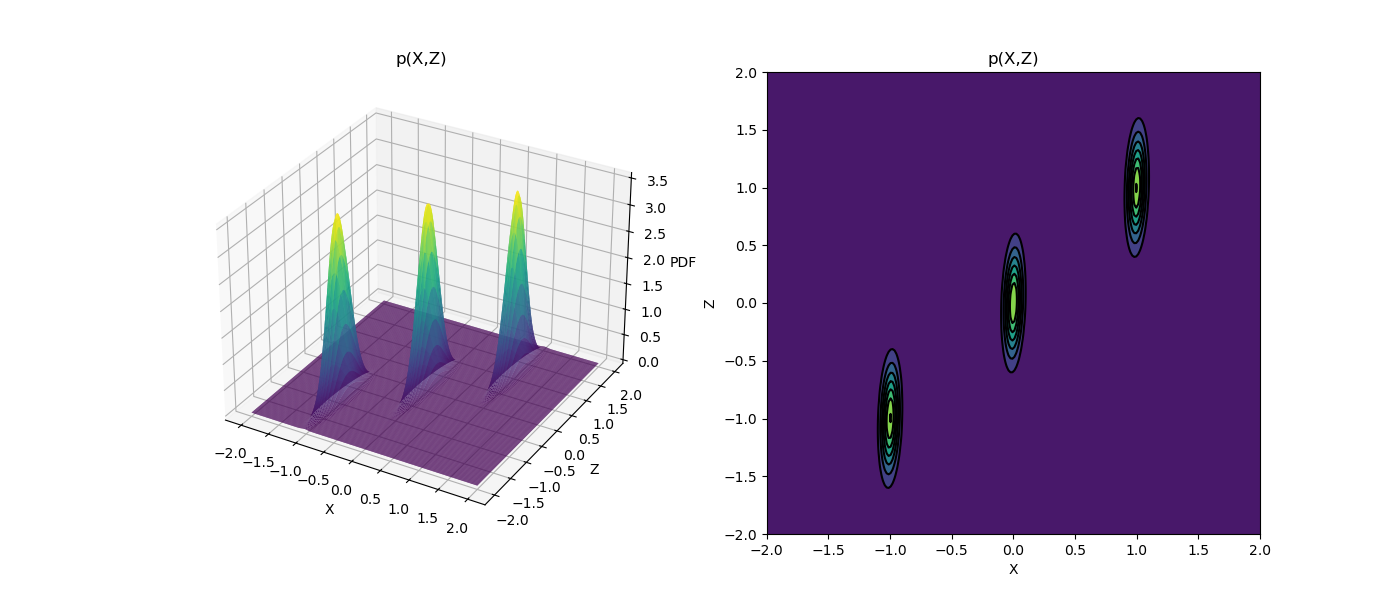

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import pyplot as plt
from helpers import *
%matplotlib widget

ck_list = np.array([-1,0,1])
sig_list = np.array(3*[0.05**2])
w_list = np.array([1/3,1/3,1/3])
sigz = 0.3**2
res = 256
xmin = -2.0
xmax = 2.

class Prob:
    def __init__(self, c_k, sig_k, sigz, w_k):
        
        self.c_k = c_k 
        self.sig_k = sig_k 
        self.sigz = sigz 
        self.w_k = w_k 

    def p_XZ(self,x): # Joint P(X,Z)
        p=0
        for c_k, sig_k, w_k in zip(self.c_k, self.sig_k, self.w_k):
            sig_k = np.array([[sig_k,sig_k],[sig_k,sig_k+self.sigz]])
            mu_k = np.array([[c_k],[c_k]])
            p+= w_k * 1/(2*np.pi)*np.linalg.det(sig_k)**(-.5)*np.exp(-.5*(np.einsum('ij,ji->i',(x-mu_k).T,np.linalg.inv(sig_k)@(x-mu_k))))

        return p
    
    def p_Z(self,x): # Marginal p(Z)
        p = 0
        for c_k, sig_k, w_k in zip(self.c_k, self.sig_k, self.w_k):
            p+= w_k*self.gauss(x,c_k,sig_k+self.sigz)
            
        return p
    
    def p_X(self,x): # Marginal p(X)
        p = 0
        for c_k, sig_k, w_k in zip(self.c_k, self.sig_k, self.w_k):
            p+= w_k*self.gauss(x,c_k,sig_k)
            
        return p
    
    def w_XgZ(self,z): # w_X|Z posterior weights of each component
    
        w_list = []
        for c_k, sig_k, w_k in zip(self.c_k, self.sig_k, self.w_k):
            w_list.append(w_k*self.gauss(z,c_k,sig_k+self.sigz)/self.p_Z(z))
    
        return w_list
    
    def p_XgZ(self,x,z): #Posterior P(X|Z) 
        w_XgZ = self.w_XgZ(z)
        mu_XgZ = self.mu_XgZ(z)
        sig_XgZ = self.sig_XgZ(z)
        
        p=0
        for c_k, sig_k, w_k in zip(mu_XgZ, sig_XgZ, w_XgZ):
            p+=w_k*self.gauss(x,c_k,sig_k)
            
        return p
    
    
    def med_XgZ(self,z,rng=[-2,2]): # Expected Value (MMSE, Posterior Mean)
        
        median = []
        xn = np.linspace(rng[0],rng[1],5000)
        
        for zn in z:
            csum = np.cumsum(self.p_XgZ(xn,zn))
            csum/=csum[-1]
            median.append(xn[np.argmin((csum-0.5)**2)])
            
        return np.array(median)
            
        
    
    def exp_XgZ(self,z): # Expected Value (MMSE, Posterior Mean)
    
        w_XgZ = self.w_XgZ(z)
        c_k = self.mu_XgZ(z)
        exp=0
        for c_k, sig_k, w_k in zip(c_k, self.sig_k, w_XgZ):
            exp+=w_k*c_k

        return exp
    
    def mu_XgZ(self,z): # posterior means of each component
        
        mu_list = []
        for c_k, sig_k, w_k in zip(self.c_k, self.sig_k, self.w_k):
            mu_list.append(c_k+sig_k/(sig_k+self.sigz)*(z-c_k))
        return mu_list
    
    
    def sig_XgZ(self,z): # posterior variance of each component
        
        sig_list = []
        for c_k, sig_k, w_k in zip(self.c_k, self.sig_k, self.w_k):
            sig_list.append(sig_k-sig_k**2/(sig_k+self.sigz))
        return sig_list
    
        
    def var_XgZ(self,z): # Posterior Variance

        w_XgZ = self.w_XgZ(z)
        exp_XgZ = self.exp_XgZ(z)
        mu_XgZ = self.mu_XgZ(z)
        sig_XgZ = self.sig_XgZ(z)
        
        var = 0
        for c_k, sig_k, w_k in zip(mu_XgZ, sig_XgZ, w_XgZ):
            
            var+= w_k*(sig_k + c_k**2)
            
        return var-exp_XgZ**2
    
    def constant(self):
        p=0
        for sig_k, w_k in zip(self.sig_k, self.w_k):
            sig_k = np.array([[sig_k,sig_k],[sig_k,sig_k+self.sigz]])
            p+= w_k*np.linalg.det(sig_k)**(-.5)
        
        return p

    
    @staticmethod #Univariate Gaussian PDF
    def gauss(x,mu,sig):
        return 1/np.sqrt(2*np.pi*sig)*np.exp(-0.5*(x-mu)**2/sig) 
    
    @staticmethod #Bivariate Gaussian PDF
    def multivariate_gauss(x,mu,sig):
        return 1/(2*np.pi)*np.linalg.det(sig)**(-.5)*np.exp(-.5*(np.einsum('ij,ji->i',(x-mu).T,np.linalg.inv(sig)@(x-mu))))
    
    
# Plot the distribution

prob = Prob(ck_list,sig_list,sigz,w_list)


yy, xx = np.mgrid[xmin:xmax:res*1j, xmax:xmin:res*1j]
positions = np.vstack([xx.ravel(), yy.ravel()])
zz = prob.p_XZ(positions).reshape(xx.shape)


fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('PDF')
ax.set_title('p(X,Z)')

ax = fig.add_subplot(1, 2, 2)
cfset = ax.contourf(xx, yy, zz, cmap='viridis')
cset = ax.contour(xx, yy, zz, colors='k')#,[(np.max(zz)*0.68)**(0.5)]
#ax.clabel(cset, inline=1, fontsize=12)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_title('p(X,Z)')

#plt.savefig('PDF.pdf',bbox_inches='tight')



# Compute 1-D example

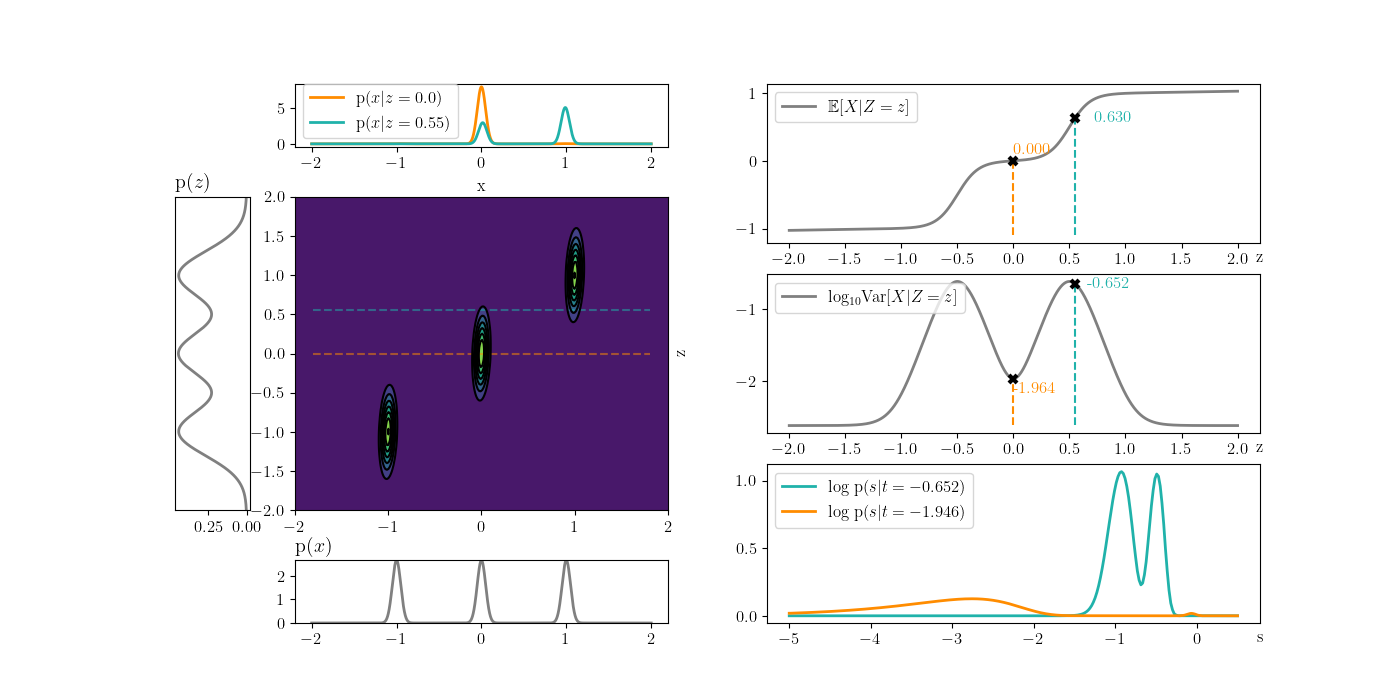

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman",
    "font.size":12,
    "text.latex.preamble": r"\usepackage{amsfonts}"
})

cZ1 = 'lightseagreen'
cZ2 = 'darkorange'

#define two values for the conditionals

Z1 = 0.55
Z2 = 0.0

x = np.linspace(xmin,xmax,5000)#torch.tensor()


# Make Plot for the 1-D example
fig = plt.figure(figsize=(14,7))

axCenter = fig.add_subplot(1, 2, 1)
divider = make_axes_locatable(axCenter)
axleft = divider.append_axes('left', size='20%', pad=0.45)
axtop = divider.append_axes('top', size='20%', pad=0.5)
axbottom = divider.append_axes('bottom', size='20%', pad=0.5)


axCenter.contourf(xx, yy, zz, cmap='viridis')
axCenter.set_xlabel('x')
axCenter.xaxis.set_label_position("top")
axCenter.set_ylabel('z')
axCenter.yaxis.set_label_position("right")
axCenter.plot([-1.8,1.8],[Z1,Z1],'--', color = cZ1,alpha = 0.5)
axCenter.plot([-1.8,1.8],[Z2,Z2],'--', color = cZ2,alpha = 0.5)
cset = axCenter.contour(xx, yy, zz, colors='k')


axtop.plot(x, prob.p_XgZ(x,Z2), linewidth = 2, color = cZ2,alpha=1,label=r'$\rm{p}$$(x|z='+str(Z2)+')$')
axtop.plot(x, prob.p_XgZ(x,Z1), linewidth = 2, color = cZ1,alpha=1,label=r'$\rm{p}$$(x|z='+str(Z1)+')$')
axtop.legend()

axbottom.plot(x, prob.p_X(x), linewidth = 2, color = 'gray')
axbottom.set_title(r'$\rm{p}$$(x)$',loc='left')

axleft.plot(prob.p_Z(x),x, linewidth = 2, color = 'gray')
axleft.set_title(r'$\rm{p}$$(z)$',loc='left')
axleft.invert_xaxis()
axleft.get_yaxis().set_visible(False)

axleft.margins(y=0)
axbottom.margins(y=0)


ax = fig.add_subplot(3, 2, 2)
ax.plot(x, prob.exp_XgZ(x),alpha = 1,c='gray',linewidth = 2)

ax.plot([Z1,Z1],[-1.1,prob.exp_XgZ(Z1)],'--', color = cZ1)
mmse = prob.exp_XgZ(Z1)
plt.plot(Z1,mmse,'x', color = 'black', mew=3, ms=6)
ax.text(Z1+(Z1*0.3),mmse-(mmse*0.1),'%.3f'%(mmse), color = cZ1)

ax.plot([Z2,Z2],[-1.1,prob.exp_XgZ(Z2)],'--', color = cZ2)
mmse = prob.exp_XgZ(Z2)
plt.plot(Z2,mmse,'x', color = 'black', mew=3, ms=6)
ax.text(Z2+(Z2*0.3),mmse-(mmse*0.1)+0.1,'%.3f'%(mmse), color = cZ2)


ax.legend([r'$\rm{\mathbb{E}}$$[X|Z=z]$'])#,'p(z)'])
ax.set_xlabel('z')
ax.xaxis.set_label_coords(1, -0.05)

ax = fig.add_subplot(3, 2, 4)
ax.plot(x, np.log10(prob.var_XgZ(x)),alpha = 1,c='gray',linewidth = 2)

ax.plot([Z1,Z1],[-2.6, np.log10(prob.var_XgZ(Z1))],'--', color = cZ1)
ax.plot(Z1,np.log10(prob.var_XgZ(Z1)),'x', color = 'black', mew=3, ms=6)
logvar = np.log10(prob.var_XgZ(Z1))
ax.text(Z1+(Z1*0.2),logvar+(logvar*0.1),'%.3f'%(logvar), color = cZ1)

ax.plot([Z2,Z2],[-2.6, np.log10(prob.var_XgZ(Z2))],'--', color = cZ2)
ax.plot(Z2,np.log10(prob.var_XgZ(Z2)),'x', color = 'black', mew=3, ms=6)
logvar = np.log10(prob.var_XgZ(Z2))
ax.text(Z2+(Z2*0.2),logvar+(logvar*0.1),'%.3f'%(logvar), color = cZ2)

ax.legend([r'$\rm{log_{10}Var}$$[X|Z=z]$'],loc='upper left')
ax.set_xlabel('z')
ax.xaxis.set_label_coords(1, -0.05)

# Compute the analytic joint (needed for bottom right plots and plots in next cell)

var_space = np.linspace(-2.65,-0.6,res)
err_space = np.linspace(-10,0.5,res)[::-1]

prob = Prob(ck_list,sig_list,sigz,w_list)

p_TS = compute_p_TS(err_space, var_space,[-8,8], res, prob)
factor=2
p_TS_resized = cv2.resize(np.log(p_TS + 1)[0:int(res//factor)],(res,res))


ax = fig.add_subplot(3, 2, 6)

pxZ1 = int((var_space[0]- np.log10(prob.var_XgZ(Z1)))/(var_space[0]-var_space[-1])*res)
pxZ2 = int((var_space[0]- np.log10(prob.var_XgZ(Z2)))/(var_space[0]-var_space[-1])*res)

pyZ1 = int((err_space[0]- -0.377)/(err_space[0]-err_space[int((res-1)/factor)])*res)
pyZ2 = int((err_space[0]- -2.147)/(err_space[0]-err_space[int((res-1)/factor)])*res)


cs1 = np.cumsum(p_TS_resized[:,pxZ1][::-1])
cs2 = np.cumsum(p_TS_resized[:,pxZ2][::-1])

ax.plot(np.linspace(err_space[0],err_space[-1]//factor,res),p_TS_resized[:,pxZ1],alpha = 1,c=cZ1,linewidth = 2,label =r'$\rm{log \hspace{.3em}p}$$(s|t=-0.652)$')
ax.plot(np.linspace(err_space[0],err_space[-1]//factor,res),p_TS_resized[:,pxZ2],alpha = 1,c=cZ2,linewidth = 2,label =r'$\rm{log \hspace{.3em}p}$$(s|t=-1.946)$')


ax.legend(loc='upper left')
ax.set_xlabel('s')
ax.xaxis.set_label_coords(1, -0.05)
plt.savefig('PDF.pdf',bbox_inches='tight')

# Plot the Joint distribution of s and t

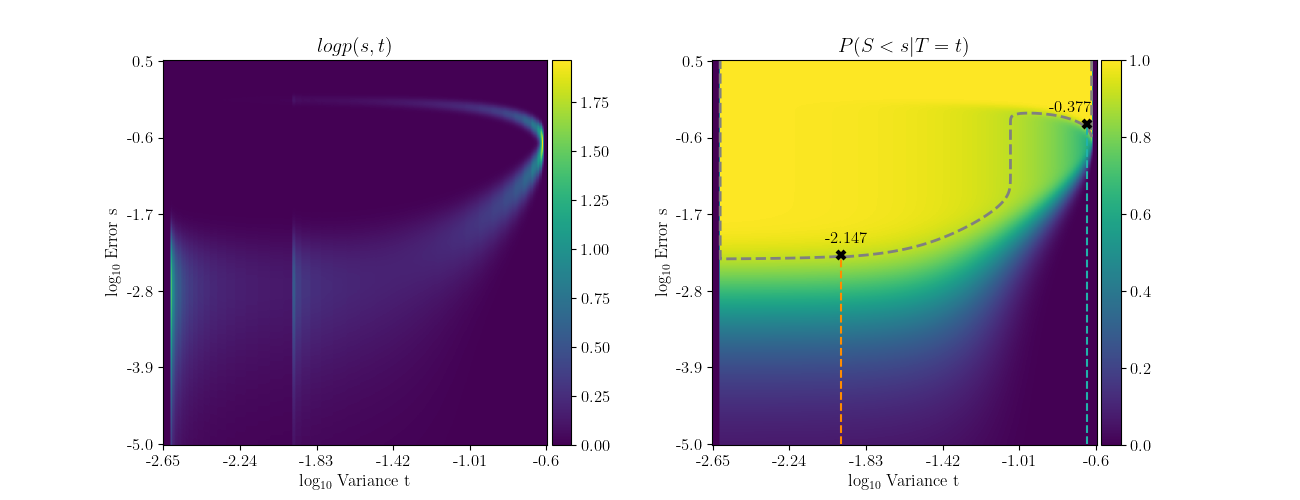

In [3]:
# Plot joint analytic
import cv2
from matplotlib import pyplot as plt


cumsuma = np.cumsum((p_TS[::-1,:]),0)[::-1,:]
temp = cumsuma[0,:].copy()
cumsuma/=(cumsuma[0,:]+1e-9)

plt.figure(figsize=(13,5))
plt.subplot(121)
#plt.imshow(np.log10(A4+1),alpha = 1.0,vmin=0)
plt.imshow(p_TS_resized)
plt.xticks(np.linspace(0,res-1,6).astype(int), np.round(np.linspace(var_space[0],var_space[-1],6),2))
plt.yticks(np.linspace(0,res-1,6).astype(int), np.round(np.linspace(err_space[0],err_space[-1]//factor,6),2))
cbar = plt.colorbar(pad=0.01)
plt.xlabel(r'$\rm{log_{10}}$ Variance t')
plt.ylabel(r'$\rm{log_{10}}$ Error s')
plt.title(r'$log p(s,t)$')

plt.subplot(122)
plt.imshow(cumsuma,alpha = 1.0)
plt.imshow(cv2.resize(cumsuma[0:int(res//factor)],(res,res)),alpha = 1.0)
plt.xticks(np.linspace(0,res-1,6).astype(int), np.round(np.linspace(var_space[0],var_space[-1],6),2))
plt.yticks(np.linspace(0,res-1,6).astype(int), np.round(np.linspace(err_space[0],err_space[-1]//factor,6),2))

xx, yy = np.meshgrid(np.linspace(0,res-1,res), np.linspace(0,res-1,res))
cbar = plt.colorbar(pad=0.01)
cset = plt.contour(xx, yy, cv2.resize(cumsuma[0:int(res//factor)],(res,res)),[0.9], colors='gray', alpha=1, linewidths=2.0,linestyles='dashed')

plt.xlabel(r'$\rm{log_{10}}$ Variance t')
plt.ylabel(r'$\rm{log_{10}}$ Error s')
plt.title(r'$P(S<s|T=t)$')



plt.plot([pxZ1,pxZ1],[res-1,pyZ1],'--', color = 'lightseagreen')
plt.plot(pxZ1,pyZ1,'x', color = 'black', mew=3, ms=6)
plt.text(pxZ1-25,pyZ1-8,'%.3f'%(-0.377))


plt.plot([pxZ2,pxZ2],[res-1,pyZ2],'--', color = 'darkorange')
plt.plot(pxZ2,pyZ2,'x', color = 'black', mew=3, ms=6)
plt.text(pxZ2-10,pyZ2-8,'%.3f'%(-2.147))

plt.savefig("Cumulative_analytic.pdf",bbox_inches='tight')

# Now with sampling

/tmp/ipykernel_593616/426240747.py:41: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  cset.collections[0].set_label('d')


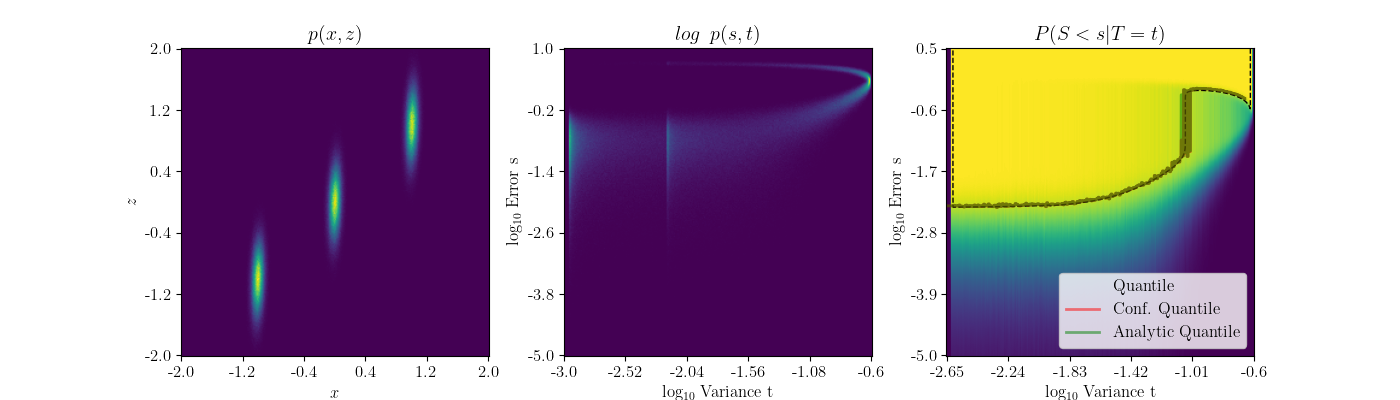

In [4]:
# Plot joint empirical

import importlib
from helpers import get_equidistant_quantile

def plot_stats(xz,st):
    factor = 2

    plt.figure(figsize = (14,4))
    plt.subplot(131)
    hist,xa,ya = np.histogram2d(xz[:,0,0],xz[:,1,0],bins=(res,res),density = True,range=[[xmin, xmax],[xmin, xmax]])
    plt.imshow((np.rot90(hist,1)))
    plt.xticks(np.linspace(0,res-1,6).astype(int), np.round(np.linspace(xmin,xmax,6),2))
    plt.yticks(np.linspace(0,res-1,6).astype(int), np.round(np.linspace(xmax,xmin,6),2))
    plt.xlabel(r'$x$')
    plt.ylabel(r'$z$')
    plt.title(r'$p(x,z)$')


    plt.subplot(132)
    hist,xe,ye = np.histogram2d(st[0,:,0],st[1,:,0],bins=(res,res),density = True,range=[[-2.65, -.6],[-10, .5]])
    plt.imshow(np.log(np.rot90(hist)+1))
    plt.xticks(np.linspace(0,res-1,6).astype(int), np.round(np.linspace(-3, -.6,6),2))
    plt.yticks(np.linspace(0,res-1,6).astype(int), np.round(np.linspace(1, -5,6),2))
    plt.xlabel(r'$\rm{log_{10}}$ Variance t')
    plt.ylabel(r'$\rm{log_{10}}$ Error s')
    plt.title(r'$log \hspace{.5em} p(s,t)$')

    plt.subplot(133)
    hist = np.histogram2d(st[0,:,0],st[1,:,0],bins=(res,res),density = True,range=[[-2.65, -.6],[-10, .5]])[0]
    cum = np.cumsum(np.rot90(hist)[::-1],0)[::-1]
    cum/=cum[0,:]+1e-12
    
    f_corrected = get_equidistant_quantile(10**st[1,:,0], 10**st[0,:,0], res, .9, corrected=True, clean_outliers=False)
    f__not_corrected = get_equidistant_quantile(10**st[1,:,0], 10**st[0,:,0], res, .9, corrected=False, clean_outliers=False)

    plt.imshow(cv2.resize(cum[0:int(res//factor)],(res,res)))
    plt.xticks(np.linspace(0,res-1,6).astype(int), np.round(np.linspace(-2.65, -.6,6),2))
    plt.yticks(np.linspace(0,res-1,6).astype(int), np.round(np.linspace(.5, -5,6),2))
    cset = plt.contour(xx, yy, cv2.resize(cumsuma[0:int(res//factor)],(res,res)),[0.9], colors='black', alpha=1, linewidths=1.0,linestyles='dashed')
    cset.collections[0].set_label('d')
    
    mask = np.sum(hist, 0, keepdims=False) > 0
    idd = np.where(mask > 0)[0]
    sx,ex = idd[0],res-idd[-1]
    space = np.linspace(sx, res - ex, 10000)
    spacex = np.linspace(xe[sx],xe[sx:-ex or None][-1],10000)

    plt.plot(space-0.5, ((np.clip(f__not_corrected(spacex), -5, .5) - ye[-1]) / (ye[0] - ye[-1])) * res * factor,c='red', linewidth=2.0, alpha=0.5)
    plt.plot(space-0.5, ((np.clip(f_corrected(spacex), -5, .5) - ye[-1]) / (ye[0] - ye[-1])) * res * factor,c='green', linewidth=2.0, alpha=0.5)
    
    plt.xlabel(r'$\rm{log_{10}}$ Variance t')
    plt.ylabel(r'$\rm{log_{10}}$ Error s')
    plt.title(r'$P(S<s|T=t)$')
    plt.legend(['Quantile','Conf. Quantile','Analytic Quantile'],loc=4)

sig = []
mu = []
w = []

inter_s = 1000000

for c_k, sig_k, w_k in zip(prob.c_k, prob.sig_k, prob.w_k):
    sig.append(np.array([[sig_k,sig_k],[sig_k,sig_k+prob.sigz]]))
    mu.append(np.array([[c_k],[c_k]]))
    w.append(w_k) 


sig= np.array(sig)
mu = np.array(mu)
w = np.array(w)
L = np.linalg.cholesky(sig)


idx = np.random.choice(np.arange(len(mu)),inter_s,p = w)
rand = np.random.randn(inter_s,2)


xz = mu[idx]+ np.einsum('bij,bj->bi',L[idx],rand)[:,:,None]
x = xz[:,0]
z = xz[:,1]


exp = prob.exp_XgZ(z)
t =  np.log10(prob.var_XgZ(z))
s = np.log10((exp-x)**2)
st = np.array([t,s])

plot_stats(xz,st);
